<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0707/Weight_and_bias_practice_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Augmentation(증강) with split-folders

In [12]:
!pip install split-folders

In [13]:

import os

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pickle
from tqdm.notebook import tqdm

import splitfolders

## Download Dataset(캐글에서 데이터셋 다운로드받기)

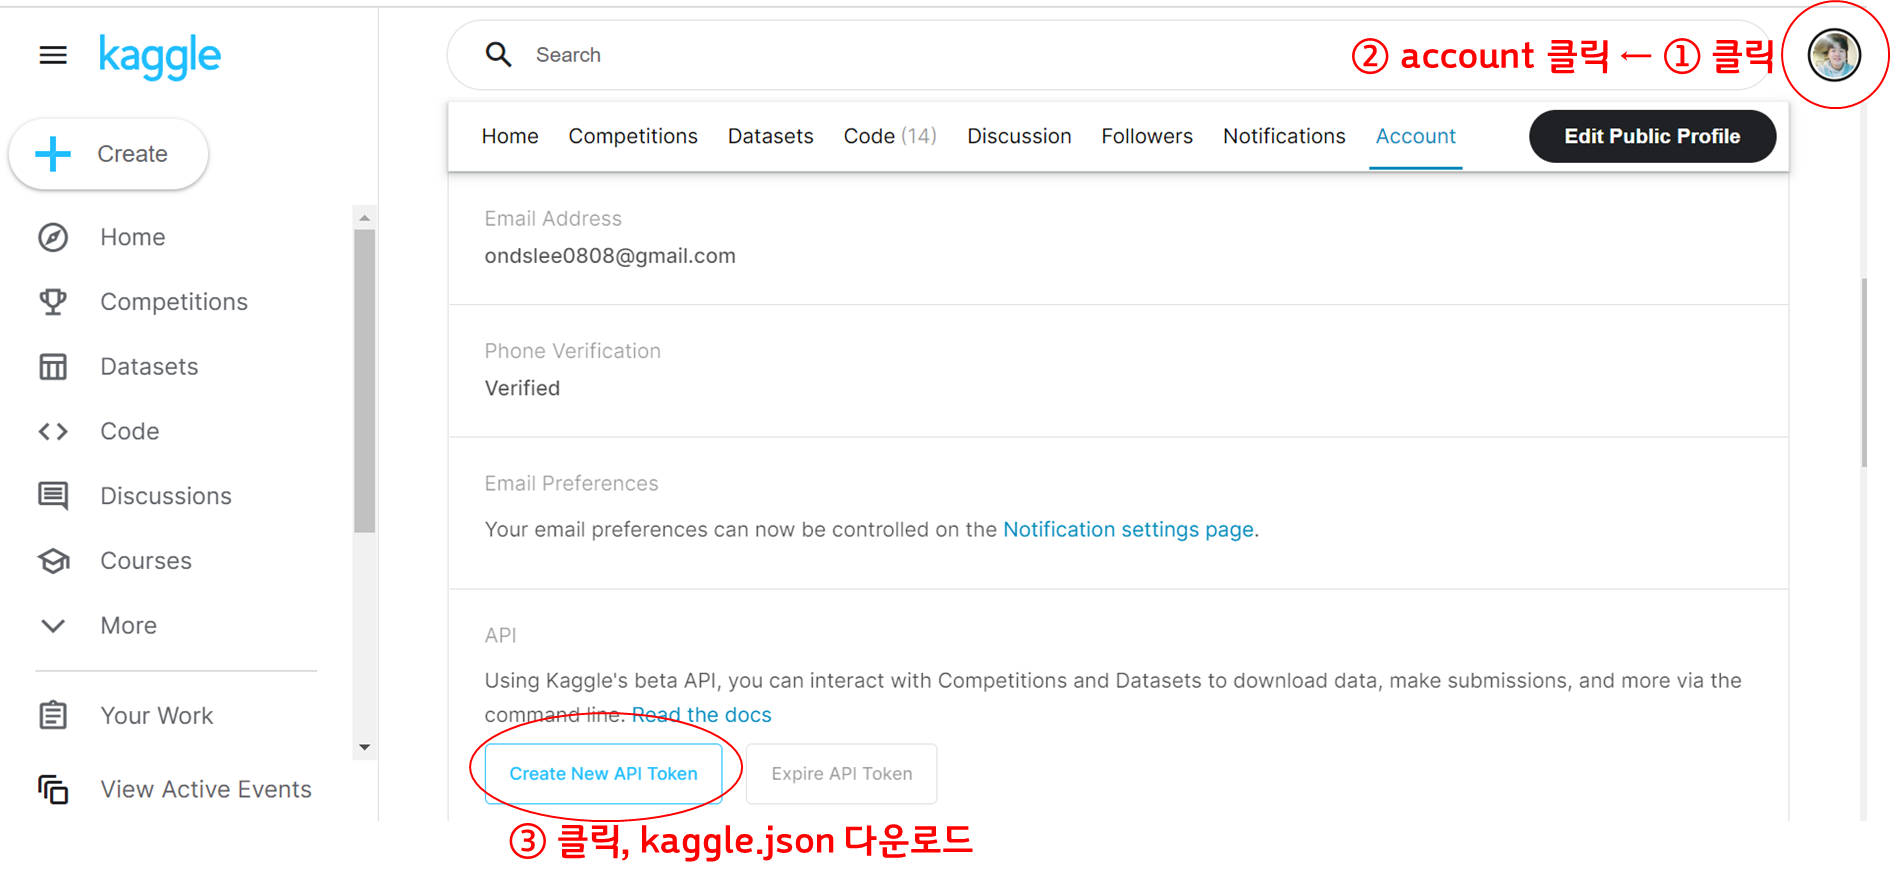

In [14]:
# 캐글 설치
!pip install -q kaggle

- kaggle.json 파일이 현재 content 경로에 있음
- root/.kaggle 폴더로 이동시켜줘야 함
--------------------------------
- root는 ~로 표시함
- .kaggle폴더는 없기 때문에 우리가 직접 만들어줘야함

In [15]:
# .kaggle 폴더 생성
!mkdir -p ~/.kaggle/
# kaggle.josn .kaggle로 복사
!cp kaggle.json ~/.kaggle/
# 해당 폴더 목록 확인(복사 잘 되었는지 확인)
!ls ~/.kaggle

kaggle.json


- root 경로에 .kaggle폴더가 잘 만들어졌는지 확인하고 싶다면
- root경로의 목록에 .kaggle폴더가 있는지 확인만 하면 됨
-----------
1) root경로로 이동 (cd ~)   
2) root 경로의 목록을 확인 (!ls -a)

In [16]:
!cd ~/ # 경로 이동 (~:루트경로로 이동)

In [17]:
!ls -a # 해당 경로 목록 전부(-a: 숨김파일까지) 확인

.  ..  .config	.ipynb_checkpoints  kaggle.json  sample_data


In [7]:
!ls ~/.kaggle -al # 해당 경로 목록 상세정보까지(-al: 권한정보, 날짜) 확인

total 16
drwxr-xr-x 2 root root 4096 Jul  7 05:48 .
drwx------ 1 root root 4096 Jul  7 05:48 ..
-rw-r--r-- 1 root root   67 Jul  7 05:48 kaggle.json


In [18]:
# 파일 권한 변경 : 읽기, 쓰기, 실행 (rwx)
!chmod 600 ~/.kaggle/kaggle.json

1) 파일권한 : 읽기, 쓰기, 실행 (rwx)  
2) 대상 : 소유자, 소유그룹, others  
3) 권한 표시 : 2진법을 8진법으로  
- 권한부여는 1, x는 0
- rwx 모두 부여는 111 -> 7
- rwx 모두 미부여는 000 -> 0


In [19]:
!ls .kaggle -al

ls: cannot access '.kaggle': No such file or directory


In [20]:
cd /content

/content


In [21]:
!ls

kaggle.json  sample_data


In [22]:
!ls -a

.  ..  .config	.ipynb_checkpoints  kaggle.json  sample_data


In [23]:
!pwd

/content


In [24]:
#downloading dataset
!kaggle datasets download -d prasunroy/natural-images

 97% 332M/342M [00:02<00:00, 194MB/s]
100% 342M/342M [00:02<00:00, 169MB/s]


In [25]:
!unzip -q natural-images.zip

In [26]:
folder_path = '/content/natural_images'
label_names = os.listdir(folder_path)
label_names

['cat', 'person', 'fruit', 'dog', 'airplane', 'flower', 'motorbike', 'car']

In [27]:
os.mkdir('/content/resize')
for label in label_names:
    dir_path = '/content/resize/'+ label
    os.mkdir(dir_path)

In [ ]:
# 카테고리별로 이미지파일 경로 리스트 사전 만들기
# keys : 카테고리명
# values : 리스트 of 이미지 경로들
dataset = {} # 카테고리명 : [이미지1경로, 이미지2경로, ...]

for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

dataset

## Resize with padding

In [29]:
label2index = {'airplane' : 0, 'car' : 1 , 'cat' : 2 , 'dog' : 3,
               'flower' : 4, 'fruit' : 5, 'motorbike' : 6, 'person' : 7}

In [30]:
def resize_img(img_path, img_size=224):
    img = cv2.imread(img_path)

    if(img.shape[1] > img.shape[0]) :
        ratio = img_size/img.shape[1]
    else :
        ratio = img_size/img.shape[0]

    img = cv2.resize(img, dsize=(0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_LINEAR)

    # 그림 주변에 검은색으로 칠하기
    w, h = img.shape[1], img.shape[0]

    dw = (img_size-w)/2 # img_size와 w의 차이
    dh = (img_size-h)/2 # img_size와 h의 차이

    M = np.float32([[1,0,dw], [0,1,dh]])  #(2*3 이차원 행렬)
    img_re = cv2.warpAffine(img, M, (224, 224)) #이동변환
    cv2.imwrite('/content/resize/{0}/{1}'.format(label, img_path.split("/")[-1]) , img_re)

In [31]:
# 이미지 리사이즈
# 1. 이미지 하나씩 읽어들여서
# 2. 리사이즈한다음
# 3. images, labels 생성
for label, img_paths in dataset.items():
    for img_path in img_paths:
        resize_img(img_path, img_size=224)

## Split Dataset

In [32]:
splitfolders.ratio('/content/resize', output='dataset', seed=77, ratio=(0.6, 0.2, 0.2))

Copying files: 6899 files [00:01, 4041.58 files/s]


## Compute trainset mean image

In [33]:
folder_path = '/content/dataset/train'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

dataset

{'cat': ['/content/dataset/train/cat/cat_0568.jpg',
  '/content/dataset/train/cat/cat_0872.jpg',
  '/content/dataset/train/cat/cat_0389.jpg',
  '/content/dataset/train/cat/cat_0702.jpg',
  '/content/dataset/train/cat/cat_0745.jpg',
  '/content/dataset/train/cat/cat_0369.jpg',
  '/content/dataset/train/cat/cat_0153.jpg',
  '/content/dataset/train/cat/cat_0478.jpg',
  '/content/dataset/train/cat/cat_0001.jpg',
  '/content/dataset/train/cat/cat_0595.jpg',
  '/content/dataset/train/cat/cat_0180.jpg',
  '/content/dataset/train/cat/cat_0603.jpg',
  '/content/dataset/train/cat/cat_0055.jpg',
  '/content/dataset/train/cat/cat_0456.jpg',
  '/content/dataset/train/cat/cat_0685.jpg',
  '/content/dataset/train/cat/cat_0787.jpg',
  '/content/dataset/train/cat/cat_0106.jpg',
  '/content/dataset/train/cat/cat_0510.jpg',
  '/content/dataset/train/cat/cat_0631.jpg',
  '/content/dataset/train/cat/cat_0026.jpg',
  '/content/dataset/train/cat/cat_0860.jpg',
  '/content/dataset/train/cat/cat_0768.jpg',
  '

In [34]:
x_train = []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_train.append(image)

x_train = np.array(x_train)

In [35]:
n_train = x_train.shape[0]

In [36]:
# zero-centering
compute_mean = lambda imgs : np.mean(imgs, axis=0)

In [37]:
mean_img = compute_mean(x_train)
mean_img.shape

(224, 224, 3)

In [38]:
sub_mean_img = lambda image : image.astype('int8') - mean_img.astype('int8')

## ImageDataGenerator 설정

In [39]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=sub_mean_img
)

val_datagen = ImageDataGenerator(
    preprocessing_function=sub_mean_img)

test_datagen = ImageDataGenerator(
    preprocessing_function=sub_mean_img)

#### flow_from_directory 이용하기

In [40]:
batch_size = 128

In [41]:
train_generator = train_datagen.flow_from_directory('/content/dataset/train',batch_size=batch_size, target_size=(224, 224))
val_generator = val_datagen.flow_from_directory('/content/dataset/val',batch_size=batch_size, target_size=(224, 224))
test_generator = test_datagen.flow_from_directory('/content/dataset/test',batch_size=batch_size, target_size=(224, 224))

Found 4136 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.
Found 1386 images belonging to 8 classes.


## 모델 학습 및 검증

In [42]:
# modeling
def create_model():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(8)
            ])

    return model

In [43]:
model = create_model()

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [44]:
steps_per_epoch = n_train // batch_size
steps_per_epoch

32

In [45]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch,
          validation_data=val_generator, epochs=3)

Epoch 1/3
32/32 [==============================] - 70s 2s/step - loss: 8.0040 - accuracy: 0.1190 - val_loss: 9.3325 - val_accuracy: 0.1445
Epoch 2/3
32/32 [==============================] - 64s 2s/step - loss: 7.7290 - accuracy: 0.1467 - val_loss: 10.1287 - val_accuracy: 0.1547
Epoch 3/3
32/32 [==============================] - 64s 2s/step - loss: 8.8898 - accuracy: 0.1544 - val_loss: 8.8944 - val_accuracy: 0.1656


In [46]:
model.evaluate(test_generator)

11/11 [==============================] - 5s 396ms/step - loss: 8.9128 - accuracy: 0.1443


[8.912823677062988, 0.14430014789104462]

In [47]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.7/211.7 kB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=49e355b4dcfe6544203c03153874ce608ec8c5c96794e1a1fc33adbc194b03ae
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [48]:
import wandb

In [49]:
from wandb.keras import WandbCallback

In [50]:
wandb.init(entity="wandb", project="keras-intro")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [51]:
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.learning_rate = 0.01
config.batch_size = 128
...
config.activation = 'relu'
config.optimizer = 'nadam'

In [52]:
optimizer = tf.keras.optimizers.Nadam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

In [53]:
model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

In [54]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch,
          validation_data=val_generator, callbacks=[WandbCallback(data_type="image", validation_data=val_generator, labels=label_names), tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], epochs=10)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


Epoch 1/10
2/2 [==============================] - 0s 9ms/step


wandb: Adding directory to artifact (/content/wandb/run-20230707_060945-j2f2k3dg/files/model-best)... Done. 9.9s


32/32 [==============================] - 101s 3s/step - loss: 8.0753 - accuracy: 0.1400 - val_loss: 6.2303 - val_accuracy: 0.1089
Epoch 2/10
32/32 [==============================] - 71s 2s/step - loss: 8.6437 - accuracy: 0.1307 - val_loss: 9.8501 - val_accuracy: 0.0959
Epoch 3/10
32/32 [==============================] - 67s 2s/step - loss: 8.6745 - accuracy: 0.1083 - val_loss: 8.6765 - val_accuracy: 0.1111
Epoch 4/10
32/32 [==============================] - 75s 2s/step - loss: 8.2459 - accuracy: 0.1312 - val_loss: 6.5530 - val_accuracy: 0.1627
Epoch 5/10
32/32 [==============================] - 70s 2s/step - loss: 7.6117 - accuracy: 0.1467 - val_loss: 6.8672 - val_accuracy: 0.1612
Epoch 6/10
32/32 [==============================] - 68s 2s/step - loss: 7.3782 - accuracy: 0.1477 - val_loss: 6.9986 - val_accuracy: 0.1590
Epoch 7/10
32/32 [==============================] - 68s 2s/step - loss: 7.1481 - accuracy: 0.1430 - val_loss: 6.7587 - val_accuracy: 0.1554
Epoch 8/10
32/32 [============

In [55]:
wandb.login() # 다실 할 때는 여기서 부터

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [56]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
from wandb.keras import WandbCallback
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [57]:
import random

In [58]:
sweep_config = {
    'method': 'bayes'
    }


In [59]:
metric = {
    'name': 'val_loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

In [60]:

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'dropout': {
          'values': [0.1, 0.3, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

In [61]:

parameters_dict.update({
    'epochs': {
        'value': 1}
    })

In [62]:
import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.001,
        'max': 0.1
      },
    'batch_size': {
        'values': [64, 128]
      }
    })


In [63]:
def create_model_for_wandb(dropout):
    model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(8)
            ])

    return model

In [71]:
def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and sgd with momentum"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.1)

Error in callback <function _WandbInit._resume_backend at 0x7f7a8c524700> (for pre_run_cell):


BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7f7c0c567370> (for post_run_cell):


BrokenPipeError: ignored

In [64]:
def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep
      model = create_model_for_wandb(wandb.config.dropout)
      model.compile(loss = "categorical_crossentropy", optimizer = get_optimizer(wandb.config.learning_rate, wandb.config.optimizer), metrics=['accuracy'])
      steps_per_epoch = n_train // wandb.config.batch_size
      model.fit(train_generator, steps_per_epoch=steps_per_epoch,
          validation_data=val_generator, callbacks=[WandbCallback(data_type="image", validation_data=val_generator, labels=label_names), tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], epochs=10)

In [65]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-keras-clf")

Create sweep with ID: q0fy6lwg
Sweep URL: https://wandb.ai/guscldns/sweeps-keras-clf/sweeps/q0fy6lwg


In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=10)

Error in callback <function _WandbInit._resume_backend at 0x7f7a8c524700> (for pre_run_cell):


BrokenPipeError: ignored

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


2/2 [==============================] - 0s 8ms/step


Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 255, in check_network_status
    self._loop_check_status(
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 211, in _loop_check_status
    local_handle = request()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/interface.py", line 795, in deliver_network_status
    return self._deliver_network_status(status)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/interface/interface_shared.py", line 601, in _deliver_network_status
    self.run()
  File "/usr/lib/p

Epoch 1/10


Done. 8.3s


32/32 [==============================] - 91s 3s/step - loss: 7.7437 - accuracy: 0.1375 - val_loss: 4.7021 - val_accuracy: 0.1438
Epoch 2/10
33/64 [==============>...............] - ETA: 1:48 - loss: 5.6428 - accuracy: 0.1325

2/2 [==============================] - 0s 9ms/step
Epoch 3/10


wandb: Adding directory to artifact (/content/wandb/run-20230707_063306-4on6635s/files/model-best)... 

 2/32 [>.............................] - ETA: 1:18 - loss: 7.1393 - accuracy: 0.1875

Done. 6.1s


64/64 [==============================] - 159s 2s/step - loss: 5.6428 - accuracy: 0.1325 - val_loss: 4.3938 - val_accuracy: 0.1220


16/32 [==============>...............] - ETA: 47s - loss: 6.5236 - accuracy: 0.1606

accuracy,▁█
epoch,█▁
loss,█▁
val_accuracy,█▁
val_loss,█▁
accuracy,0.1325
best_epoch,0
best_val_loss,4.39378
epoch,0
loss,5.6428
val_accuracy,0.122


18/32 [===============>..............] - ETA: 41s - loss: 6.6109 - accuracy: 0.1576

wandb: Agent Starting Run: i5s45a0c with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	learning_rate: 0.08303998759330146
wandb: 	optimizer: sgd


23/32 [====================>.........] - ETA: 24s - loss: 6.6187 - accuracy: 0.1539

 8/32 [======>.......................] - ETA: 1:44 - loss: 6.0198 - accuracy: 0.1562

wandb: Adding directory to artifact (/content/wandb/run-20230707_063639-i5s45a0c/files/model-best)... 

10/32 [========>.....................] - ETA: 1:28 - loss: 6.1401 - accuracy: 0.1602

Done. 7.5s


32/32 [==============================] - 117s 4s/step - loss: 3.0494 - accuracy: 0.1121 - val_loss: 2.2202 - val_accuracy: 0.1024
Epoch 2/10
32/32 [==============================] - 131s 4s/step - loss: 5.8845 - accuracy: 0.1659 - val_loss: 4.9857 - val_accuracy: 0.1765
Epoch 5/10
15/32 [=============>................] - ETA: 58s - loss: 5.4590 - accuracy: 0.1392 

wandb: Adding directory to artifact (/content/wandb/run-20230707_063639-i5s45a0c/files/model-best)... 

17/32 [==============>...............] - ETA: 49s - loss: 5.4678 - accuracy: 0.1375

Done. 6.0s


32/32 [==============================] - 126s 4s/step - loss: 5.2892 - accuracy: 0.1417 - val_loss: 4.7180 - val_accuracy: 0.1452
Epoch 6/10
22/32 [===================>..........] - ETA: 34s - loss: 5.9938 - accuracy: 0.1393

wandb: Adding directory to artifact (/content/wandb/run-20230707_063639-i5s45a0c/files/model-best)... 

24/32 [=====================>........] - ETA: 27s - loss: 6.0588 - accuracy: 0.1384

Done. 6.2s


32/32 [==============================] - 108s 3s/step - loss: 6.1304 - accuracy: 0.1395 - val_loss: 6.5306 - val_accuracy: 0.1532
Epoch 7/10
2/2 [==============================] - 0s 9ms/step
Epoch 8/10
 2/32 [>.............................] - ETA: 53s - loss: 7.7637 - accuracy: 0.1328

wandb: Adding directory to artifact (/content/wandb/run-20230707_063639-i5s45a0c/files/model-best)... 

 3/32 [=>............................] - ETA: 1:45 - loss: 7.3979 - accuracy: 0.1276

Done. 4.2s


32/32 [==============================] - 122s 4s/step - loss: 2.0853 - accuracy: 0.1130 - val_loss: 2.0519 - val_accuracy: 0.1060
Epoch 5/10
2/2 [==============================] - 0s 10ms/step
Epoch 9/10
 1/32 [..............................] - ETA: 1:58 - loss: 7.2599 - accuracy: 0.1016

wandb: Adding directory to artifact (/content/wandb/run-20230707_063639-i5s45a0c/files/model-best)... 

 2/32 [>.............................] - ETA: 2:24 - loss: 7.1285 - accuracy: 0.1016

Done. 4.8s


 4/32 [==>...........................] - ETA: 1:44 - loss: 5.3758 - accuracy: 0.1108

In [ ]:
!wandb login --relogin